<style>
    .zero-margin {
        margin: 0 px;
     }
</style>

<div class="zero-margin" style="text-align: center;">
    <p style="text-align: center; font-size: 30px; margin-bottom: 15px;">Recommendation System Exercise<p>
    <p  style="text-align: center; margin-bottom: 0px;">Friday, November 15th 2019</p>
     <p  style="text-align: center; margin-top: 0px;">Herdis Haerussalam & Haries Ramdhani</p>
</div>

### Introduction

For the purpose of this exercise, we're trying to implement recommendation systems. The recommendation systems that we tried to implement are as follows:
1. **Apriori Algorithm** (Association Rules)  
Apriori is an algorithm for frequent item set mining and association rule learning over relational databases. It proceeds by identifying the frequent individual items in the database and extending them to larger and larger item sets as long as those item sets appear sufficiently often in the database.

    For implementing this, we're using the bread basket dataset
     <br/><br/>
2. **Collaborative Filtering**  
Collaborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating).

    For implementing this, we're using the wine review dataset, consisting of 130k reviews
     <br/><br/>
3. **Content-based**  
Content-based recommenders treat recommendation as a user-specific classification problem and learn a classifier for the user's likes and dislikes based on product features. In this system, keywords are used to describe the items and a user profile is built to indicate the type of item this user likes.

    For implementing this, we're using the wine review dataset, consisting of 130k reviews
    <br/><br/>
4. **Hybrid Recommender System**
Hybrid Recommender system is a combination of several recommender systems for this purpose the implemented Conten-based and Collaborative Filtering are used.

    For implementing this, we're still using the wine review dataset, consisting of 130k reviews
    <br/><br/>
5. **Content-based (E-commerce Product)**  
For implementing this, we're using the e-commerce product descriptions

### Apriori Algorithm

In [61]:
# Import required library
import pandas as pd
from mlxtend.frequent_patterns import apriori,association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations, groupby
import os

In [64]:
# load dataset
df = pd.read_csv('data/BreadBasket_DMS.csv')
df.head(5)

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


In [65]:
# looking for datashape
df.shape

(21293, 4)

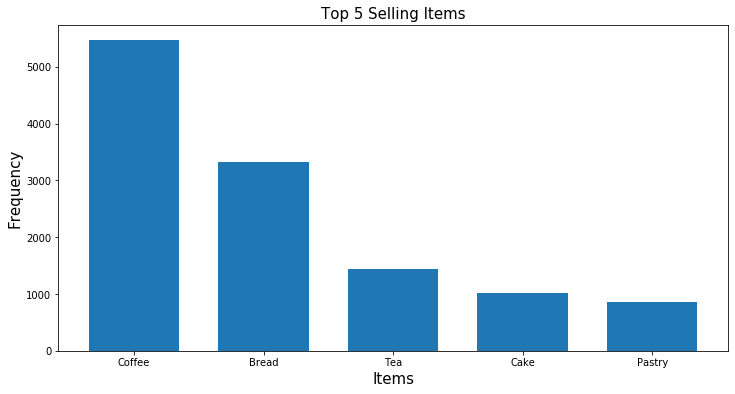

In [66]:
# what the interesting things from data
items = df['Item'].value_counts().index
item_frequency = df['Item'].value_counts().values

plt.figure(figsize=(12,6))
plt.xlabel('Items', fontsize='15')
plt.ylabel('Frequency', fontsize='15')
plt.title('Top 5 Selling Items', fontsize='15')
plt.bar(items[:5],item_frequency[:5], width = 0.7, color="tab:blue",linewidth=0.4)
plt.show()

It seems like coffee are the most frequent in dataset.

In [67]:
df2 = df.groupby(['Transaction','Item']).size().reset_index(name='count')
basket = (df2.groupby(['Transaction', 'Item'])['count']
          .sum().unstack().reset_index().fillna(0)
          .set_index('Transaction'))
#The encoding function
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
basket_sets = basket.applymap(encode_units)

In [68]:
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift")
rules.sort_values('confidence', ascending = False, inplace = True)
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
44,(Toast),(Coffee),0.033365,0.475081,0.023502,0.704403,1.482699,0.007651,1.775789
43,(Spanish Brunch),(Coffee),0.018046,0.475081,0.010807,0.598837,1.260494,0.002233,1.308493
29,(Medialuna),(Coffee),0.061379,0.475081,0.034939,0.569231,1.198175,0.005779,1.218561
34,(Pastry),(Coffee),0.085510,0.475081,0.047214,0.552147,1.162216,0.006590,1.172079
2,(Alfajores),(Coffee),0.036093,0.475081,0.019515,0.540698,1.138116,0.002368,1.142861
27,(Juice),(Coffee),0.038296,0.475081,0.020460,0.534247,1.124537,0.002266,1.127031
32,(NONE),(Coffee),0.079005,0.475081,0.042073,0.532537,1.120938,0.004539,1.122908
36,(Sandwich),(Coffee),0.071346,0.475081,0.037981,0.532353,1.120551,0.004086,1.122468
16,(Cake),(Coffee),0.103137,0.475081,0.054349,0.526958,1.109196,0.005350,1.109667
38,(Scone),(Coffee),0.034309,0.475081,0.017941,0.522936,1.100729,0.001642,1.100310


From the data frame above we can see that the highest lift is obtained by the toast and the coffee with a lift score of 1.48, followed by spanish brunch and coffee. The assumption for toast and coffee is the fact that both of em are probably consumed in the morning together.

### Collaborative Filtering, Content-Based and Hybrid Recommender System

In [3]:
# Load the essential 
import numpy as np
import pandas as pd 

# Load the library for the recommendation system
import surprise as sp

#### Data Preparation

In [4]:
df = pd.read_csv("data/wine.csv")

In [5]:
# Preview of the data
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


#### Filter Data
Get only the columns that we want and rename the columns name

In [6]:
df = df[['country','province','region_1','variety','price','taster_name','points']]
df = df.rename(columns={'region_1': 'region'}).dropna(subset=['country','province','region','variety','taster_name','points'])

In [7]:
df.head()

,country,province,region,variety,price,taster_name,points
0,Italy,Sicily & Sardinia,Etna,White Blend,NaN,Kerin O’Keefe,87
2,US,Oregon,Willamette Valley,Pinot Gris,14.0,Paul Gregutt,87
3,US,Michigan,Lake Michigan Shore,Riesling,13.0,Alexander Peartree,87
4,US,Oregon,Willamette Valley,Pinot Noir,65.0,Paul Gregutt,87
5,Spain,Northern Spain,Navarra,Tempranillo-Merlot,15.0,Michael Schachner,87


#### Group Wine By Region

In [9]:
wines = df.groupby(['country', 'province', 'region', 'variety']).agg({'price': 'mean'}).reset_index()
wines = wines.assign(id=pd.Series(range(1, wines.shape[0]+1), dtype=int, index=wines.index))
wines = wines[['id', 'country', 'province', 'region', 'variety', 'price']]

In [10]:
wines.head()

,id,country,province,region,variety,price
0,1,Argentina,Mendoza Province,Agrelo,Bonarda,17.857143
1,2,Argentina,Mendoza Province,Agrelo,Bordeaux-style Red Blend,34.500000
2,3,Argentina,Mendoza Province,Agrelo,Cabernet Franc,40.800000
3,4,Argentina,Mendoza Province,Agrelo,Cabernet Sauvignon,20.250000
4,5,Argentina,Mendoza Province,Agrelo,Chardonnay,15.000000


#### Group the User Data (Taster Data)

In [11]:
users = df.groupby('taster_name').count().reset_index()[['taster_name']]
users = users.assign(id=pd.Series(range(1, users.shape[0]+1), dtype=int, index=users.index))

In [12]:
users.head()

,taster_name,id
0,Alexander Peartree,1
1,Anna Lee C. Iijima,2
2,Anne Krebiehl MW,3
3,Carrie Dykes,4
4,Christina Pickard,5


#### Create the User and Wine ID Dict

In [17]:
wine_id_dict = {(row['country'], row['province'], row['region'], row['variety']): row['id'] for index, row in wines.iterrows()}
user_id_dict = {row['taster_name']: row['id'] for index, row in users.iterrows()}

In [18]:
def get_wine_id_series(data_frame):
    return pd.Series((wine_id_translator[(row['country'], row['province'], row['region'], row['variety'])] for _, row in data_frame.iterrows()), index=data_frame.index)

def get_user_id_series(data_frame):
    return pd.Series((user_id_translator[row['taster_name']] for _, row in data_frame.iterrows()), index=data_frame.index)

#### Aggregate Average Points of All Ratings

In [20]:
ratings = df.assign(wine_id=get_wine_id_series, user_id=get_user_id_series)[['taster_name', 'user_id', 'wine_id', 'points']].groupby(['user_id', 'taster_name', 'wine_id']).mean().reset_index()

#### Filter the Data by Threshold

In [21]:
THRESHOLD = 3
filtered_wines = list(ratings.groupby(['wine_id']).count()[lambda x: x['points'] >= THRESHOLD].reset_index()['wine_id'].values)

In [23]:
ratings = ratings.loc[ratings['wine_id'].isin(filtered_wines)].astype({'wine_id': int, 'user_id': int}).reset_index(drop=True)
wines = wines.loc[wines['id'].isin(filtered_wines)].astype({'id': int}).reset_index(drop=True)
users = users.loc[users['id'].isin(ratings['user_id'].values)].astype({'id': int}).reset_index(drop=True)

#### Preview of the Cleaned Data

In [25]:
ratings.head()

,user_id,taster_name,wine_id,points
0,1,Alexander Peartree,5069,87.666667
1,1,Alexander Peartree,5737,89.000000
2,1,Alexander Peartree,5738,86.750000
3,1,Alexander Peartree,5741,86.250000
4,1,Alexander Peartree,5743,88.000000


In [26]:
wines.head()

,id,country,province,region,variety,price
0,739,Canada,Ontario,Niagara Peninsula,Riesling,42.423077
1,741,Canada,Ontario,Niagara Peninsula,Vidal Blanc,62.615385
2,757,France,Alsace,Alsace,Gewürztraminer,34.206897
3,760,France,Alsace,Alsace,Pinot Blanc,17.622047
4,778,France,Alsace,Crémant d'Alsace,Sparkling Blend,24.886256


In [27]:
users.head()

,taster_name,id
0,Alexander Peartree,1
1,Anna Lee C. Iijima,2
2,Anne Krebiehl MW,3
3,Carrie Dykes,4
4,Christina Pickard,5


### Collaborative Filtering
`collaborative_filtering` function will return the predicted rating of the user with `taster_name` for wine with id `wine_id`. This function uses a KNN classifier. To train the model, all other ratings are used.

In [28]:
def collaborative_filtering(ratings, taster_name, wine_id):
    is_target = (ratings['taster_name'] == taster_name) & (ratings['wine_id'] == wine_id)
    target = ratings[is_target].iloc[0]
    
    train_set = sp.Dataset.load_from_df(
        ratings[~is_target][['user_id', 'wine_id', 'points']], 
        sp.Reader(rating_scale=(0, 100))
    ).build_full_trainset()

    algo = sp.KNNBasic(verbose=False)
    algo.fit(train_set)
    prediction = algo.predict(target['user_id'], target['wine_id'], verbose=False)
    return prediction.est, prediction.est - target['points'], target['points']

### Content-Based
`content_based` returns the predicted rating of the user with name `taster_name` for item with id `wine_id`.
The function also uses a KNN classifier. To train the model, all other ratings from the same user, as well as the wine database are used.
The error and the actual rating is returned as well.

In [29]:
# Content-Based

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

def content_based(ratings, wines, taster_name, wine_id):
    user_ratings = ratings[ratings['taster_name'] == taster_name].join(wines.set_index('id'), on='wine_id')
    is_target = (user_ratings['wine_id'] == wine_id)
    
    features = pd.get_dummies(user_ratings.drop(columns=['points']))
    train_features = features[~is_target]
    target_features = features[is_target]
    
    encoder = LabelEncoder()
    train_labels = encoder.fit_transform(user_ratings[~is_target]['points'])
    target_label = user_ratings[is_target]['points'].iloc[0]

    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(train_features, train_labels)
    prediction = encoder.inverse_transform(clf.predict(target_features))[0]
    return prediction, prediction - target_label, target_label

#### Testing the Recommenders

In [30]:
def test_classifier(taster_name, wine_id):
    pred_cf, error_cf, truth = collaborative_filtering(ratings, taster_name, wine_id)
    pred_cn, error_cn, truth = content_based(ratings, wines, taster_name, wine_id)
    print("Results for {} on wine with id {}:".format(taster_name, wine_id))
    print("Collaborative Filtering: \t prediction: {:.5f} \t error: {:.5f}".format(pred_cf, error_cf))
    print("Content-Based: \t\t\t prediction: {:.5f} \t error: {:.5f}".format(pred_cn, error_cn))

These two examples are used to test our collaborative filtering and content-based recommender system. For this purpose taster with the name `Carrie Dykes` and `Christina Pickard` is used for testing and the wine id that is used for testing is the wine with id of 741. The prediction is at 89.6550 for collaborative filtering and 89.5 for content-based. Looking at this fact we can say that Collaborative Filtering and Content-based suggested that Carrie Dykes will like the wine.

In [34]:
test_classifier(taster_name='Carrie Dykes', wine_id=741)

Results for Carrie Dykes on wine with id 741:
Collaborative Filtering: 	 prediction: 89.65560 	 error: -0.01107
Content-Based: 			 prediction: 89.50000 	 error: -0.16667


In [35]:
test_classifier(taster_name='Christina Pickard', wine_id=741)

Results for Christina Pickard on wine with id 4147:
Collaborative Filtering: 	 prediction: 87.93883 	 error: 2.83883
Content-Based: 			 prediction: 85.50000 	 error: 0.40000


### Hybrid Recommender System
For the purpose of hybrid recommender system weighted soft voting method is created, the soft voting is based on the results of `collaborative_filtering` and `content_based`. For testing the hybrid recommender system the same taster is used `Carrie Dykes` and as can be seen from the results we see an increase in prediction and reduce in error.

In [36]:
def hybrid_cf_cb(ratings, wines, taster_name, wine_id):
    prediction_cf, _, truth = predict_cf(ratings, taster_name, wine_id)
    prediction_cn, _, truth = predict_cn(ratings, wines, taster_name, wine_id)
    
    # Weights can be chosen differently, depending on 
    # the (assumed) quality of the recommenders
    prediction = 0.5 * prediction_cf + 0.5 * prediction_cn
    error = prediction - truth
    return prediction, error, truth


pred_weighted, error_weighted, truth = hybrid_cf_cb(ratings, wines, taster_name='Carrie Dykes', wine_id=741)
print("Weighted Hybrid: \t prediction: {:.5f} \t error: {:.5f}".format(pred_weighted, error_weighted))

Weighted Hybrid: 	 prediction: 89.57780 	 error: -0.08887


### Content-Based Recommender System (Item-Based)

For the purpose of this exercise called content based recommender system. We're trying to find the similar item based on the content description similarity. As we know that there are two approaches to content based recommendation system:
- **Approach 1** — Analysing Description of the Content Only
- **Approach 2** — Building User Profile and Item Profile from User Rated Content 

For this exercise the first approach will be used 

#### Dataset
The dataset is a dataset containing list of fashion products. It's a 2x500 matrix data and having only `id` and `description` columns. The description contains free text of the overview of the product and detailed description of the products that are being sold. It also has the `fabric` and `weight` information of each product.

#### Case Story
Hari wants to know which products are similar to the product that he bought, he hated the e-commerce's current recommendation system so he created his own recommendation system. For this purpose, he created a content-based recommender system by scraping the data from the 

#### Library and Data Imports

In [51]:
# Import pandas for data manipulation
import pandas as pd

# Import TfidVectorizer for converting text to the TFIF matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Import sklearn for calculating the similarity
from sklearn.metrics.pairwise import linear_kernel 

In [52]:
# Display the HTML in the description
from IPython.core.display import display, HTML

# For Regex purposes
import re

# Import nltk module 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\m.haris01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
# Load the dataset
df = pd.read_csv("data/cbrs_data.csv")

In [54]:
# Preview of the dataset
df.shape

(500, 2)

In [55]:
# Preview of the first data
display(HTML(df.loc[3].values[1]))

#### Lower Casing

In [44]:
df["description"] = df["description"].str.lower()

#### Punctuation Removal

In [45]:
df["description"] = df["description"].apply(lambda x : re.sub(r'[^\w\s]', '', x))

#### Stopwords Removal

In [46]:
stop = stopwords.words('english')

df["description"] = df["description"].apply(lambda x: " ".join(list(set(x.split()) - set(stop))))

#### Recommender System

In [56]:
# Create tfidf vector from the description column
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')

tfidf_matrix = tf.fit_transform(df['description'])

In [57]:
# Calcualting the cosine similarities between the tfidf matrices
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix) 
results = {}

for idx, row in df.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1] 
    similar_items = [(cosine_similarities[idx][i], df['id'][i]) for i in similar_indices] 
    results[row['id']] = similar_items[1:]

In [58]:
def item(id):  
    return df.loc[df['id'] == id]['description'].tolist()[0].split(' - ')[0]

def recommend(item_id, num):
    print(f"Top {num} products similar to the {item(item_id)}")   
    print("-------")    
    recs = results[item_id][:num]   

    for i, rec in enumerate(recs): 
        print(f"{i+1}. {item(rec[1])} (SCORE: {rec[0]})")

We created the content-based recommender system based on `cosine_similarity`. For example, we want to check the product similar to the `item_id` 4.

In [60]:
recommend(item_id=4, num=10)

Top 10 products similar to the Alpine guide pants
-------
1. Alpine guide pants (SCORE: 0.8253856759948797)
2. Guide jkt (SCORE: 0.20769755384994887)
3. Guide jkt (SCORE: 0.18827991801713145)
4. Rock guide pants (SCORE: 0.16574026828699218)
5. Lw guide pants (SCORE: 0.16373827536275246)
6. Lw guide pants (SCORE: 0.16057322023890835)
7. Simple guide pants (SCORE: 0.15095357533978407)
8. Simple guide jkt (SCORE: 0.14280033047131765)
9. Simple guide jkt (SCORE: 0.1419570728794997)
10. Traverse pants (SCORE: 0.13137137380042502)
